**IMPORTING THE KAGGLE API**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/barin model'

**Downloading the required dataset form kaggle into colab**

In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

 98% 306M/312M [00:03<00:00, 118MB/s]
100% 312M/312M [00:03<00:00, 95.1MB/s]


**unziping/decompressing the dowloaded dataset**

In [ ]:
!unzip \*.zip && rm*.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         
  inflating: images/2036.png         

**Creating the Metrics**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


**Creating the UNET Model**

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # print(s1.shape, s2.shape, s3.shape, s4.shape)
    # print(p1.shape, p2.shape, p3.shape, p4.shape)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

**Training the model**

In [ ]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


""" Global parameters """
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 150
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/barin model/dataset"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/150


KeyboardInterrupt: ignored

**reading the cvs file**

In [ ]:
import pandas
 
# reading the CSV file
csvFile = pandas.read_csv('/content/drive/MyDrive/barin model/files/log.csv')
 
# displaying the contents of the CSV file
print(csvFile)

    epoch  dice_coef      loss            lr  val_dice_coef  val_loss
0       0   0.142243  0.857757  1.000000e-04       0.027138  0.972808
1       1   0.281428  0.718572  1.000000e-04       0.022070  0.977883
2       2   0.365694  0.634306  1.000000e-04       0.043548  0.956151
3       3   0.450608  0.549392  1.000000e-04       0.208054  0.789584
4       4   0.519495  0.480505  1.000000e-04       0.305557  0.695637
5       5   0.573945  0.426055  1.000000e-04       0.430943  0.568795
6       6   0.636008  0.363992  1.000000e-04       0.499925  0.497524
7       7   0.678754  0.321246  1.000000e-04       0.578165  0.414391
8       8   0.710059  0.289941  1.000000e-04       0.625579  0.366940
9       9   0.741034  0.258966  1.000000e-04       0.639932  0.359497
10     10   0.763383  0.236617  1.000000e-04       0.703747  0.294648
11     11   0.783115  0.216885  1.000000e-04       0.674132  0.324342
12     12   0.791751  0.208249  1.000000e-04       0.590549  0.409567
13     13   0.814651

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving unet.py to unet.py


{'unet.py': b'from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input\r\nfrom keras.models import Model\r\n\r\ndef conv_block(inputs, num_filters):\r\n    x = Conv2D(num_filters, 3, padding="same")(inputs)\r\n    x = BatchNormalization()(x)\r\n    x = Activation("relu")(x)\r\n\r\n    x = Conv2D(num_filters, 3, padding="same")(x)\r\n    x = BatchNormalization()(x)\r\n    x = Activation("relu")(x)\r\n\r\n    return x\r\n\r\ndef encoder_block(inputs, num_filters):\r\n    x = conv_block(inputs, num_filters)\r\n    p = MaxPool2D((2, 2))(x)\r\n    return x, p\r\n\r\ndef decoder_block(inputs, skip_features, num_filters):\r\n    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)\r\n    x = Concatenate()([x, skip_features])\r\n    x = conv_block(x, num_filters)\r\n    return x\r\n\r\ndef build_unet(input_shape):\r\n    inputs = Input(input_shape)\r\n\r\n    s1, p1 = encoder_block(inputs, 64)\r\n    s2, p2 = encoder_bloc

Testing module

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import train_test_split



""" Global parameters """
H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)


    """ Load the model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/barin model/files", "model.h5"))
    
    """ Dataset """
    dataset_path = "/content/drive/MyDrive/barin model/dataset"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    

    """ Prediction and Evaluation """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
      """ Extracting the name """
      name = x.split("/")[-1]

      """ Reading the image """
      image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
      image = cv2.resize(image, (W, H))       ## [H, w, 3]
      x = image/255.0                         ## [H, w, 3]
      x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

      """ Reading the mask """
      mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (W, H))

      """ Prediction """
      y_pred = model.predict(x, verbose=0)[0]
      y_pred = np.squeeze(y_pred, axis=-1)
      y_pred = y_pred >= 0.5
      y_pred = y_pred.astype(np.int32)

      """ Saving the prediction """
      save_image_path = os.path.join("/content/drive/MyDrive/barin model/results", name)
      save_results(image, mask, y_pred, save_image_path)

      """ Flatten the array """
      mask = mask/255.0
      mask = (mask > 0.5).astype(np.int32).flatten()
      y_pred = y_pred.flatten()

      """ Calculating the metrics values """
      f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
      jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
      recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
      precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
      SCORE.append([name, f1_value, jac_value, recall_value, precision_value])
    
    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/barin model/files/score.csv")

  0%|          | 0/612 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

**Installing the testing dataset**

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 33% 5.00M/15.1M [00:00<00:00, 47.7MB/s]
100% 15.1M/15.1M [00:00<00:00, 74.3MB/s]


In [ ]:
!unzip \*.zip && rm*.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

**individual test**


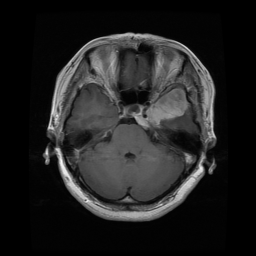

MRI IMAGE


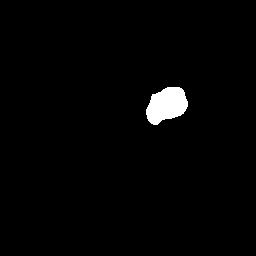

PREDICTATION IMAGE


In [ ]:
from google.colab.patches import cv2_imshow

def test_results(image, y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255
    
    cv2_imshow(image)
    print("MRI IMAGE")
    cv2_imshow(y_pred)
    print("PREDICTATION IMAGE")

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    x="/content/drive/MyDrive/barin model/dataset/images/1.png"


    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("/content/drive/MyDrive/barin model/ind", name)
    test_results(image, y_pred)





